### $\varepsilon$-Greedy Policy:
$$
\begin{array}{l}
\pi(a|s) =
\left\{
\begin{array}{ll}
1 - \varepsilon + \varepsilon / m,& \text{ если } a \in \mathrm{argmax}_{a' \in \mathcal{A}}\, Q(s,a'),\\
\varepsilon / m,& \text{ иначе }
\end{array}
\right.
\end{array}
$$

In [3]:
import numpy as np


def get_epsilon_greedy_action(q_values, epsilon, action_n):
    prob = np.ones(action_n) * epsilon / action_n
    argmax_action = np.argmax(q_values)
    prob[argmax_action] += 1 - epsilon
    action = np.random.choice(np.arange(action_n), p=prob)
    return action

### Monte-Carlo Algorithm

Пусть $Q(s,a) = 0$, $N(s,a) = 0$ и $\varepsilon = 1$.

Для каждого эпизода $k \in \overline{1,K}$ делаем:

1. Согласно $\pi = \varepsilon\text{-greedy}(Q)$ получаем траекторию $\tau = (S_0,A_0,\ldots,S_T)$ и награды $(R_0,\ldots,R_{T-1})$. По ним определяем $(G_0,\ldots,G_{T-1}):$
$$
G_t = \sum\limits_{k=t}^{T-1} \gamma^{k-t} R_t
$$

2. Для каждого $t \in \overline{0,T-1}$ обновляем $Q$ и $N$:

$$
Q(S_t,A_t) \leftarrow Q(S_t,A_t) + \frac{1}{N(S_t,A_t) + 1}\big(G_t - Q(S_t,A_t)\big),
$$

$$
N(S_t,A_t) \leftarrow N(S_t,A_t) + 1
$$
Уменьшаем $\varepsilon$


In [37]:
def MonteCarlo(env, episode_n, t_max=500, gamma=0.99):
    state_n = env.observation_space.n
    action_n = env.action_space.n
    
    Q = np.zeros((state_n, action_n))
    N = np.zeros((state_n, action_n))
    epsilon = 1
    
    total_rewards = []
    
    for episode in range(episode_n):
        states, actions, rewards = [], [], []
        
        state = env.reset()
        for t in range(t_max):
            states.append(state)
            
            action = get_epsilon_greedy_action(Q[state], epsilon, action_n)
            actions.append(action)
            
            state, reward, done, _ = env.step(action)
            rewards.append(reward)
            
            if done:
                break
                
        total_rewards.append(sum(rewards))
        
        #G = [rewards[-1]]
        #for t in range(len(rewards) - 2, -1, -1):
        #    G.append(rewards[t] + gamma * G[-1])
        # len(rewards) = 10        
        # G = [rewards[9]]
        # G = [rewards[9], rewards[8] + gamma * G[0]]
        # G = [rewards[9], rewards[8] + gamma * G[0], rewards[7] + gamma * G[1]]
        #G.reverse()
        
        G = np.zeros(t_max + 1)
        for t in range(len(rewards) - 1, -1, -1):
            G[t] = rewards[t] + gamma * G[t + 1]
            
        # len(rewards) = 10
        # t = 9 G[9] = reward[9] + gamma * G[10] = reward[9]
        # t = 8 G[8] = reward[8] + gamma * G[9]
        
        for t in range(len(rewards)):
            Q[states[t]][actions[t]] += (G[t] - Q[states[t]][actions[t]]) / (1 + N[states[t]][actions[t]])
            N[states[t]][actions[t]] += 1
        
        epsilon -= 1 / episode_n
        
    return total_rewards

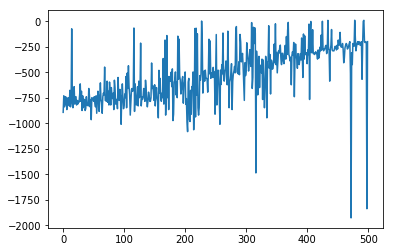

In [40]:
import gym
import matplotlib.pyplot as plt

env = gym.make("Taxi-v2")

total_rewards = MonteCarlo(env, episode_n=500, t_max=1000, gamma=0.99)

plt.plot(total_rewards)
plt.show()

### SARSA Algorithm 
Пусть $Q(s,a) = 0$ и $\varepsilon = 1$.

Для каждого эпизода $k$ делаем:

Пока эпизод не закончен делаем:

1. Находясь в состоянии $S_t$ совершаем действие $A_t \sim \pi(\cdot|S_t)$, 
где $\pi = \varepsilon\text{-greedy}(Q)$, получаем награду $R_t$, переходим в состояние $S_{t+1}$, совершаем действие $A_{t+1} \sim \pi(\cdot|S_{t+1})$

2. По $(S_t,A_t,R_t,S_{t+1},A_{t+1})$ обновляем $Q$:
$$
Q(S_t,A_t) \leftarrow Q(S_t,A_t) + \alpha(R_t + \gamma Q(S_{t+1},A_{t+1}) - Q(S_t,A_t))
$$

Уменьшаем $\varepsilon$


In [24]:
def SARSA(env, episode_n, noisy_episode_n, gamma=0.99, t_max=500, alpha=0.5):
    state_n = env.observation_space.n
    action_n = env.action_space.n
    
    Q = np.zeros((state_n, action_n))
    epsilon = 1
    
    total_rewards = []
    for episode in range(episode_n):
        
        total_reward = 0
        
        state = env.reset()
        action = get_epsilon_greedy_action(Q[state], epsilon, action_n)
        
        for t in range(t_max):
            next_state, reward, done, _ = env.step(action)
            next_action = get_epsilon_greedy_action(Q[next_state], epsilon, action_n)
            
            Q[state][action] += alpha * (reward + gamma * Q[next_state][next_action] - Q[state][action])
            
            total_reward += reward
            
            if done:
                break
                
            state = next_state
            action = next_action
            
        epsilon = max(0, epsilon - 1 / noisy_episode_n)
        
        total_rewards.append(total_reward)
        
    return total_rewards

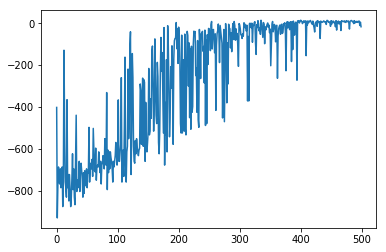

In [29]:
total_rewards = SARSA(env, episode_n=500, noisy_episode_n=400, t_max=1000, gamma=0.999, alpha=0.5)

plt.plot(total_rewards)
plt.show()

### Q-Learning Algorithm

Пусть $Q(s,a) = 0$ и $\varepsilon = 1$.

Для каждого эпизода $k$ делаем:

Пока эпизод не закончен делаем:

1. Находясь в состоянии $S_t$ совершаем действие $A_t \sim \pi(\cdot|S_t)$, 
где $\pi = \varepsilon\text{-greedy}(Q)$, получаем награду $R_t$  переходим в состояние $S_{t+1}$.

2. По $(S_t,A_t,R_t,S_{t+1})$ обновляем $Q$:
$$
Q(S_t,A_t) \leftarrow Q(S_t,A_t) + \alpha(R_t + \gamma \max\limits_{a'} Q(S_{t+1},a') - Q(S_t,A_t))
$$

Уменьшаем $\varepsilon$

In [30]:
def QLearning(env, episode_n, noisy_episode_n, gamma=0.99, t_max=500, alpha=0.5):
    state_n = env.observation_space.n
    action_n = env.action_space.n
    
    Q = np.zeros((state_n, action_n))
    epsilon = 1
    
    total_rewards = []
    for episode in range(episode_n):
        
        total_reward = 0
        state = env.reset()

        for t in range(t_max):
            action = get_epsilon_greedy_action(Q[state], epsilon, action_n)
            next_state, reward, done, _ = env.step(action)
            
            Q[state][action] += alpha * (reward + gamma * np.max(Q[next_state]) - Q[state][action])
            
            total_reward += reward
            
            if done:
                break
                
            state = next_state
            
        epsilon = max(0, epsilon - 1 / noisy_episode_n)
        
        total_rewards.append(total_reward)
        
    return total_rewards

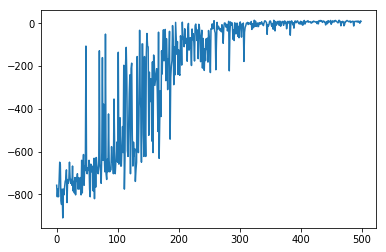

In [31]:
total_rewards = QLearning(env, episode_n=500, noisy_episode_n=400, t_max=1000, gamma=0.999, alpha=0.5)

plt.plot(total_rewards)
plt.show()